#Mounting Google Drive

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Importing Libraries


---



In [ ]:
pip install pandas-profiling

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import accuracy_score
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from pandas_profiling import ProfileReport
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

<ipython-input-4-ffb1fbbd1178>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization
<ipython-input-4-ffb1fbbd1178>:20: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import imagesize
import pandas as pd
import seaborn as sns
import gc
import keras_tuner as kt

#Loading/Preparing Data


---



In [ ]:
#Data stored in a zip file with several folders.

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-05-15 17:27:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 142.251.8.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  22.7MB/s    in 2.9s    

2023-05-15 17:27:46 (22.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
#File is zipped, unzips file and sets to read more 'r'

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
#Define cat/dog training/test file paths (4 total)

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
#Check Volume of Images (expecting 2k training data and 1k validation data with equal cat/dog images in each)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total training images:', len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print('total validation images:', len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total training images: 2000
total validation images: 1000


#Visualising the Data

---



In [ ]:
#Prints first 10 values of each directory

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.182.jpg', 'cat.701.jpg', 'cat.397.jpg', 'cat.551.jpg', 'cat.995.jpg', 'cat.262.jpg', 'cat.632.jpg', 'cat.184.jpg', 'cat.753.jpg', 'cat.383.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


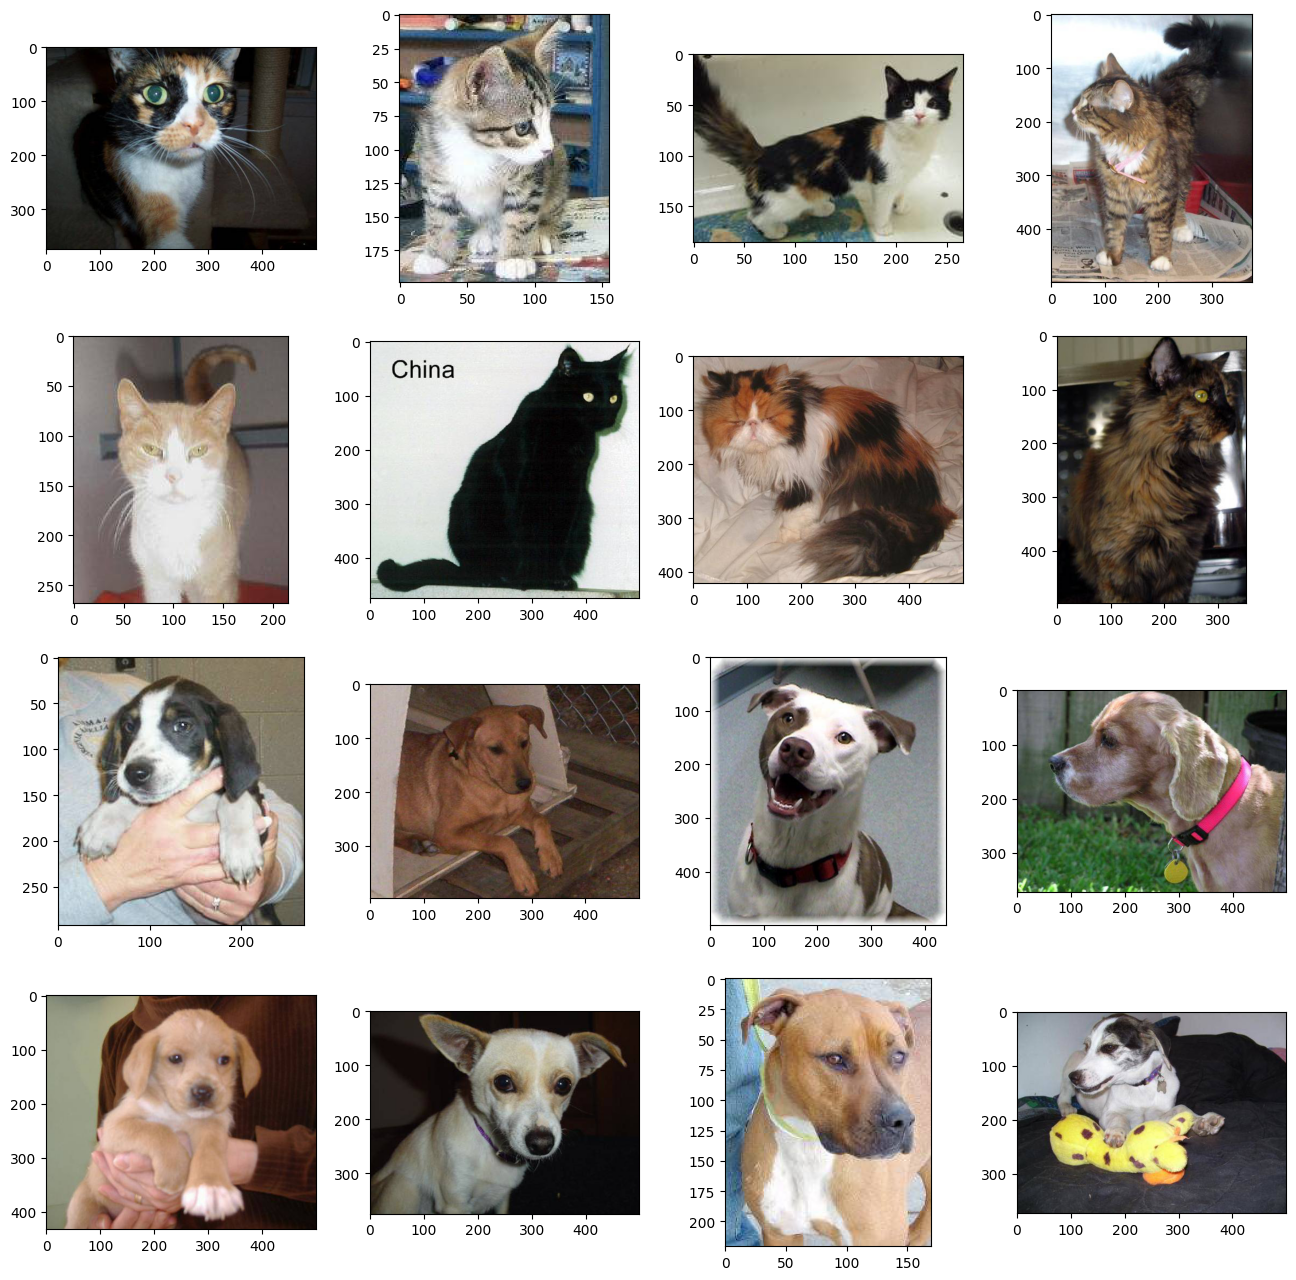

In [ ]:
# Index for iterating over images

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(16,16)

pic_index += 10
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(4, 4, i+1)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

From this plot, we can see a mix of shapes within all the images. With this, we will have to consider what shape we will standardise the images to (13).

#Exploratory Data Analysis

---




##Initial Overview of Data

---



In [ ]:
#Function to process images, appending info such as file size, category, aspect ratio etc to dataframe


def process_image_metadata(base_dir):

    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    categories = ['cats', 'dogs']
    dirs = {'train': train_dir, 'validation': validation_dir}

    img_meta = {}

    for data_type, data_dir in dirs.items():
        for category in categories:
            category_dir = os.path.join(data_dir, category)
            file_names = os.listdir(category_dir)

            for file_name in file_names:
                file_path = os.path.join(category_dir, file_name)
                img_meta[file_name] = {'Size': imagesize.get(file_path),
                                        'Category': category,
                                        'Data_Type': data_type}

    img_meta_df = pd.DataFrame(img_meta).T.reset_index().rename(columns={'index': 'FileName'})
    img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
    img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

    print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
    print('Unique Nr of Images in the dataset: ' + str(img_meta_df['FileName'].nunique()))

    return img_meta_df

In [ ]:
#Checking function has appended images to data frame
base_dir = '/tmp/cats_and_dogs_filtered'
img_meta_df = process_image_metadata(base_dir)
display()

Total Nr of Images in the dataset: 3000
Unique Nr of Images in the dataset: 3000


In [ ]:
#Creates a function which appends total pixel size to dataframe to easily be called when dataframe is updated from base directory.

def addTotalPixels(df):
  df["Total_Pixels"] = df["Width"] * df["Height"]
  return df

addTotalPixels(img_meta_df)

FileName        Size Category   Data_Type  Width  Height  \
0      cat.182.jpg  (499, 374)     cats       train    499     374   
1      cat.701.jpg  (499, 375)     cats       train    499     375   
2      cat.397.jpg  (499, 375)     cats       train    499     375   
3      cat.551.jpg  (156, 199)     cats       train    156     199   
4      cat.995.jpg  (266, 186)     cats       train    266     186   
...            ...         ...      ...         ...    ...     ...   
2995  dog.2475.jpg  (500, 374)     dogs  validation    500     374   
2996  dog.2376.jpg  (500, 374)     dogs  validation    500     374   
2997  dog.2064.jpg  (499, 338)     dogs  validation    499     338   
2998  dog.2238.jpg  (500, 374)     dogs  validation    500     374   
2999  dog.2261.jpg  (477, 500)     dogs  validation    477     500   

      Aspect Ratio  Total_Pixels  
0             1.33        186626  
1             1.33        187125  
2             1.33        187125  
3             0.78         31044  
4             1.43         49476  
...            ...           ...  
2995          1.34        187000  
2996          1.34        187000  
2997          1.48        168662  
2998          1.34        187000  
2999          0.95        238500  

[3000 rows x 8 columns]

In [ ]:
#Inital analysis of raw data

profile = ProfileReport(img_meta_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Findings from our Pandas Profile Report:

1. We have an equal number of dog and cat photos
2. All photos have unique file names
3. Currently our train/validation ratio is 2:1
4. There are 2 photos with widths > 500.
5. Large peak of aspect ratios ~1.3 suggesting common 4:3 landscape ratio is popular.


##Removing Resolution Outliers

---



###Rescaling Width Outliers

---



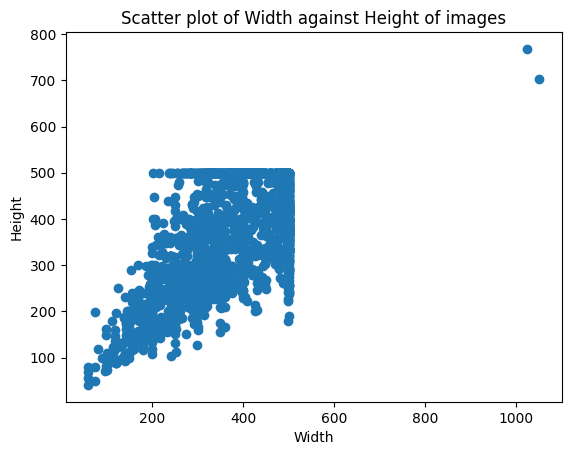

In [ ]:
#Plotting scatter chart of width against height of images

plt.scatter(img_meta_df['Width'], img_meta_df['Height'])
plt.title("Scatter plot of Width against Height of images")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

We can see two outliers on the graph identified in our pandas profile.

In [ ]:
#Locating file names of large images

img_meta_df.sort_values(by='Width', ascending =False)

FileName         Size Category   Data_Type  Width  Height  \
2801  dog.2317.jpg  (1050, 702)     dogs  validation   1050     702   
277    cat.835.jpg  (1023, 768)     cats       train   1023     768   
693    cat.861.jpg   (500, 374)     cats       train    500     374   
792    cat.242.jpg   (500, 374)     cats       train    500     374   
2199  cat.2043.jpg   (500, 427)     cats  validation    500     427   
...            ...          ...      ...         ...    ...     ...   
1133   dog.630.jpg     (73, 50)     dogs       train     73      50   
2217  cat.2433.jpg     (59, 41)     cats  validation     59      41   
1057   dog.927.jpg     (59, 80)     dogs       train     59      80   
2820  dog.2188.jpg     (59, 55)     dogs  validation     59      55   
2806  dog.2068.jpg     (59, 70)     dogs  validation     59      70   

      Aspect Ratio  Total_Pixels  
2801          1.50        737100  
277           1.33        785664  
693           1.34        187000  
792           1.34        187000  
2199          1.17        213500  
...            ...           ...  
1133          1.46          3650  
2217          1.44          2419  
1057          0.74          4720  
2820          1.07          3245  
2806          0.84          4130  

[3000 rows x 8 columns]

In [ ]:
#Creating an image resizer function

import PIL
from PIL import Image

def resizer(path):

  #Sets fixed Width
  mywidth = 150
  #Opens image from path
  img = Image.open(path)
  #Calculates height of image using aspect ratio and fixed width
  wpercent = (mywidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
  #Returns resized imaged to base directory
  return img.save(path)

In [ ]:
resizer("/tmp/cats_and_dogs_filtered/validation/dogs/dog.2317.jpg")
resizer("/tmp/cats_and_dogs_filtered/train/cats/cat.835.jpg")

In [ ]:
#Confirming images have been rescaled in base directory whilst maintaing their aspect ratio

img_meta_df = process_image_metadata(base_dir)
addTotalPixels(img_meta_df)
img_meta_df.loc[img_meta_df['FileName'].isin(["dog.2317.jpg", "cat.835.jpg"])]

Total Nr of Images in the dataset: 3000
Unique Nr of Images in the dataset: 3000


FileName        Size Category   Data_Type  Width  Height  \
277    cat.835.jpg  (150, 112)     cats       train    150     112   
2801  dog.2317.jpg  (150, 100)     dogs  validation    150     100   

      Aspect Ratio  Total_Pixels  
277           1.34         16800  
2801          1.50         15000

###Removing Small Images

---



Based on the pandas profile, to prevent any images which may suffer from compression effects or artifacts, any image below 10,000 total pixels will be removed.

In [ ]:
#Identifying small images
smallImages = img_meta_df.loc[img_meta_df['Total_Pixels'] < 10000]
smallImages

FileName       Size Category   Data_Type  Width  Height  \
129    cat.183.jpg  (105, 89)     cats       train    105      89   
473    cat.485.jpg   (99, 94)     cats       train     99      94   
735    cat.146.jpg  (80, 119)     cats       train     80     119   
790    cat.596.jpg   (95, 72)     cats       train     95      72   
1057   dog.927.jpg   (59, 80)     dogs       train     59      80   
1106   dog.990.jpg  (100, 74)     dogs       train    100      74   
1133   dog.630.jpg   (73, 50)     dogs       train     73      50   
1319   dog.943.jpg   (90, 99)     dogs       train     90      99   
1705   dog.881.jpg  (99, 100)     dogs       train     99     100   
1973   dog.296.jpg   (99, 81)     dogs       train     99      81   
2217  cat.2433.jpg   (59, 41)     cats  validation     59      41   
2436  cat.2095.jpg   (75, 79)     cats  validation     75      79   
2636  dog.2390.jpg  (100, 99)     dogs  validation    100      99   
2697  dog.2476.jpg  (105, 94)     dogs  validation    105      94   
2806  dog.2068.jpg   (59, 70)     dogs  validation     59      70   
2820  dog.2188.jpg   (59, 55)     dogs  validation     59      55   
2948  dog.2139.jpg  (99, 100)     dogs  validation     99     100   

      Aspect Ratio  Total_Pixels  
129           1.18          9345  
473           1.05          9306  
735           0.67          9520  
790           1.32          6840  
1057          0.74          4720  
1106          1.35          7400  
1133          1.46          3650  
1319          0.91          8910  
1705          0.99          9900  
1973          1.22          8019  
2217          1.44          2419  
2436          0.95          5925  
2636          1.01          9900  
2697          1.12          9870  
2806          0.84          4130  
2820          1.07          3245  
2948          0.99          9900

In [ ]:
#Create list where for loop can store paths concatinated from data in dataframe

removePaths = []

for index, row in smallImages.iterrows():
    removePath = (f"/tmp/cats_and_dogs_filtered/" + row['Data_Type'] + "/" + row['Category'] + "/" +  row['FileName'])
    removePaths.append(removePath)

removePaths

['/tmp/cats_and_dogs_filtered/train/cats/cat.183.jpg',
 '/tmp/cats_and_dogs_filtered/train/cats/cat.485.jpg',
 '/tmp/cats_and_dogs_filtered/train/cats/cat.146.jpg',
 '/tmp/cats_and_dogs_filtered/train/cats/cat.596.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.927.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.990.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.630.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.943.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.881.jpg',
 '/tmp/cats_and_dogs_filtered/train/dogs/dog.296.jpg',
 '/tmp/cats_and_dogs_filtered/validation/cats/cat.2433.jpg',
 '/tmp/cats_and_dogs_filtered/validation/cats/cat.2095.jpg',
 '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2390.jpg',
 '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2476.jpg',
 '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2068.jpg',
 '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2188.jpg',
 '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2139.jpg']

In [ ]:
#Loop to remove small images from base directory using paths previously gathered

for x in removePaths:
  os.remove(x)

In [ ]:
#No further images < 10000 total pixels remains in base directory

img_meta_df = process_image_metadata(base_dir)
addTotalPixels(img_meta_df)
img_meta_df = img_meta_df.drop(img_meta_df[img_meta_df.Total_Pixels < 10000].index)

Total Nr of Images in the dataset: 2983
Unique Nr of Images in the dataset: 2983


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 996
total training dog images: 994
total validation cat images: 498
total validation dog images: 495


We have lost some of our initial data here. However, due to the relivately small quanity of loss, this has been classed as acceptable knowing that new instances of data can be created from augmentation.

#Preparing Data for Models

---



##Creating Generators

---



As mentioned, images here have been standardised to 150 x 150. Richter et al., 2021 test numerous sizes, in this instance 150 x 150 has been chosen based on a happy medium between data quality and resource requirements. Furthermore, data normalisation as described by Singh & Singh, 2020 equalises features of data to be of the same scale, allowing for comparisons to be made by the model. Overall this improves data quality and allows for more appropriate weighting to be assigned during modeling.

In [ ]:
#As RGB values are typically represented as values from 0-255, by dividing data by 255 we can normalise these RGB values
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flows training image data in data generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  #Images are scaled to same 150x150 size
        batch_size=20, #Images are processed at this batch size
        shuffle=True, #Randomly sort the images
        class_mode='binary') #Binary labels are assinged in this scenario for binary image classifacation using binary crossentropy.

# As above but for validation data
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle = False, #Preventing shuffle allows us to make comparisons with our model
        class_mode='binary')

Found 1990 images belonging to 2 classes.
Found 993 images belonging to 2 classes.


##Appending Data from Generators

---



In [ ]:
# initialise arrays for x and y datasets
x_train, y_train = [], []
x_test, y_test = [], []

# Fors loop through both created generators and append data and labels to arrays.
for data, label in train_generator:
  x_train.append(data)
  y_train.append(label)
  if len(x_train) * train_generator.batch_size >= train_generator.samples:
    break

for data, label in validation_generator:
  x_test.append(data)
  y_test.append(label)
  if len(x_test) * validation_generator.batch_size >= validation_generator.samples:
    break

#Concatinates results from loop into numpy arrays
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

In [ ]:
#Splitting train data to create validation data. This approximately splits the data into a 50/30/20

x_train_split, x_val_split= x_train[:1500, ...], x_train[1500:, ...]

y_train_split, y_val_split= y_train[:1500, ...], y_train[1500:, ...]

In [ ]:
#Checking shapes or arrays

data = [x_train_split, x_val_split, x_test, y_train_split, y_val_split, y_test]

for i in data:
  print(i.shape)

(1500, 150, 150, 3)
(490, 150, 150, 3)
(993, 150, 150, 3)
(1500,)
(490,)
(993,)


##How the data is shaped:


---

*   X Arrays (X, B, C, D)

A is the overall number of images, e.g. 1500 total train images. B = x axis pixels of each image where C = y axis pixels. Since B = C our images are therefore square. D is the number of colour channels of data in the image, because we have insisted for RGB in this instance, 3 channels are required to represent this data.

*   Y Arrays (Y)

Y arrays store our labels for each image. As class_mode binary was chosen during the generators, this has resulted in the label for cat or dog being stored in binary format, where 1 = Dog and 0 = Cat.


*   Ratios of Data

Above splitting provides an approximate ratio of 50/30/20 in terms of train/test/validate. This isn't ideal where optimum ratios suggest at least 70% of the total data set is used to train the model. This can be solved using data augmentation (Joseph, 2022).




##Data Augmentation:


---

Within model creation, we can create additional instances of data training data from our original datasets using transformational methods such as rotation and scaling as convolutional neural network (CNNs) are regarded as non-invariant to these types of transformations. This means that without altering the structure of the model if a model's original training dataset does not have examples of scaled or rotated images, weightings and biases within the model will not exist to be able to classify images which have been transformed. Therefore, by transforming our original dataset we can create a dataset that will create different weights and biases than our original data set, allowing us to train models further with the same amount of original data (Shorten and Khoshgoftaar, 2019).





#Initial CNN

---



Model Architecture

---



*   Input Layer

Our input layer is the data we receive from our data generators. This is shaped in a 2D manner having a value for x, y and channel number. This input shape is defined in our first convolution layer where (150, 150, 3).
*   Convolution Layer

Convolution layers which can be seen multiple times in above model are key for CNN function. Conv layers are regarded as feature extractors where Kernels examine and store values of certain sized pixel clusters of an image. In this instance our Kernel is 3 x 3. The kernel will then translate across the image by a set pixel amount known as stride value where it will continuously scan the image until completion (Rosebrock, 2021).
*   Pooling Layer

Pooling layers are used for aggregating features together that convolution layers have collected, with this, features are compressed to allow for faster run times and prevent overfitting. For example, if a 4x4 image consisted of 4 2x2 kernels. The outputting pooling layer would be one 2x2 kernel which consisted of compressed data from those 4 kernels (GeeksforGeeks, 2019).
*   Fully Connected Layer

Fully connected layers have been applied as a dense layer. These are large weight matrices which augment inputs they receive from previous layers. Values of these weights within the matrices change as models learn from inputs. In this scenario we have used a fully connected to compute final outputs from the convolution and pooling layers prior to classification in the output layer (Sharma, 2020).


Hyperparameter Choices

---

*   Learning Rate(LR)

LR is the speed in which a model adapts at solving the networks problem. Meaning if a LR is closer to 1, stronger weights will be applied earlier. This often reduces the number of epochs required (Jepkoech et al., 2021).

*  Epochs

Number of times the mode iterates through the entire dataset (Afaq and Rao, 2020).

*   Activation Function(AF)

AF is the process in which an input weight is transformed at each node, this can then add further biases to the output. These can either be linear or non-linear. However, CNNs would not work with only linear functions (Dubey, Singh and Chaudhuri, 2022), if only linear layers founded all model layers, there would be no non-linearity within the model to discern data from one and other.  

*   Dropout

Dropout layers have the effect of potentially ignoring some layer outputs. Resulting in the overall layer having varying node numbers. Primary function of dropout is to create noise and disruption within the model to prevent overfitting. Dropout causes some inputs to nodes which might not be the best fit due to lost nodes (Srivastava et al., 2014).

*   Loss Function(LF)

LF compares the predictions of the model against validation data to assess training performance. Minimising this loss is key for good model performance (Nie, Hu and Li, 2018).














##Creating the CNN

---



In [ ]:
#Creating Model Helper Function

def create_model():

  #Adding layers as  with purpose previously explained
  model = tf.keras.models.Sequential()

  model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2), strides=2))

  model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
  model.add(MaxPooling2D((2, 2), strides=2))

  model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
  model.add(MaxPooling2D((2, 2), strides=2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
#Invoking model function and checking a summary

CNN = create_model()
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
#Compiling Model

CNN.compile(loss='binary_crossentropy', #Binary crossentropy as this is binary image classifacation
             optimizer='Adam',
              metrics=['acc'])

In [ ]:
#Fitting train data to model

history = CNN.fit(x_train_split,
            y_train_split,
            batch_size = 32, #Setting hyper parameters
            epochs = 10,
            validation_data = (x_val_split, y_val_split))

#Classifying results from model
y_pred = CNN.predict(x_test)
y_pred_binary = (y_pred > 0.5)

Epoch 1/10
47/47 [==============================] - 14s 35ms/step - loss: 0.6972 - acc: 0.5333 - val_loss: 0.6703 - val_acc: 0.5653
Epoch 2/10
47/47 [==============================] - 1s 17ms/step - loss: 0.6553 - acc: 0.6287 - val_loss: 0.6462 - val_acc: 0.6204
Epoch 3/10
47/47 [==============================] - 1s 17ms/step - loss: 0.6395 - acc: 0.6447 - val_loss: 0.6399 - val_acc: 0.6163
Epoch 4/10
47/47 [==============================] - 1s 17ms/step - loss: 0.6004 - acc: 0.6793 - val_loss: 0.6495 - val_acc: 0.6327
Epoch 5/10
47/47 [==============================] - 1s 18ms/step - loss: 0.5329 - acc: 0.7413 - val_loss: 0.6712 - val_acc: 0.6551
Epoch 6/10
47/47 [==============================] - 1s 18ms/step - loss: 0.4641 - acc: 0.7840 - val_loss: 0.6934 - val_acc: 0.6531
Epoch 7/10
47/47 [==============================] - 1s 18ms/step - loss: 0.3878 - acc: 0.8227 - val_loss: 0.7858 - val_acc: 0.6490
Epoch 8/10
47/47 [==============================] - 1s 18ms/step - loss: 0.2718 - 

In [ ]:
#Save model for future changes
CNN.save('my_model')

## CNN Model Evaluation

---



###Confusion Matrix


---





In [ ]:
#Creating Matrix helper function

def matrixHelper(cf_matrix, name):

  fig, ax = plt.subplots(figsize=(10,10))

  #Setting labels
  groupNames = ['True Cats','False Dogs','False Cats','True Dogs']

  #Gathering group counts and calculating percentages
  groupCounts = ["{0:0}".format(num) for num in
                cf_matrix.flatten()]
  groupPercentages = ["{0:.2%}".format(num) for num in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

  #Appending labels to groups
  labels = [f"{a} - {b} - {c}" for a, b, c in
          zip(groupNames,groupCounts,groupPercentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, cmap="coolwarm", annot = labels, fmt='', linewidth = 1, ax=ax).set(title=name)

  return plt.show()

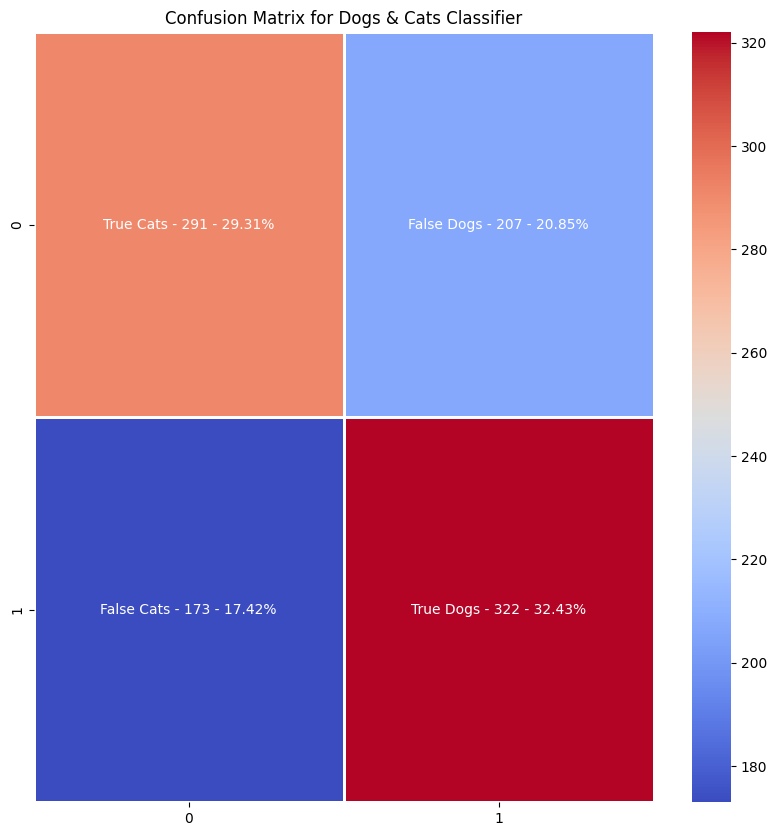

In [ ]:
#Plotting Confusion Matrix

cf_matrix = confusion_matrix(y_test, y_pred_binary)
matrixHelper(cf_matrix, 'Confusion Matrix for Dogs & Cats Classifier')

####Findings

---


Model demonstrates moderate confidence in predicting both cats and dogs as equal percentage of true dogs and true cats can be seen. Moreover, incorrect predictions seem fairly equal.


###Visualising Accuracy/Loss

---



In [ ]:
#Creating metrics helper function

def visualiseMetrics(model):

  #Getting accuracy/loss values for both training and validation data
  train_acc = model.history['acc']
  val_acc = model.history['val_acc']
  train_loss = model.history['loss']
  val_loss = model.history['val_loss']

  # Plot training and validation accuracy per epoch

  epochs = range(len(train_acc))

  #Plotting different training validation metrics
  fig, ax = plt.subplots(figsize=(10,10))
  plt.plot(epochs, train_acc, label = "Training Accuracy")
  plt.plot(epochs, val_acc, label = "Validation Accuracy")
  plt.plot(epochs, train_loss, label = "Training Loss")
  plt.plot(epochs, val_loss, label = "Validation Loss")
  plt.yticks(np.arange(0, 2, 0.1))
  plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
  plt.legend(loc = "upper left")
  plt.title('Training and Validation Accuracy/Loss')

  return plt.show()

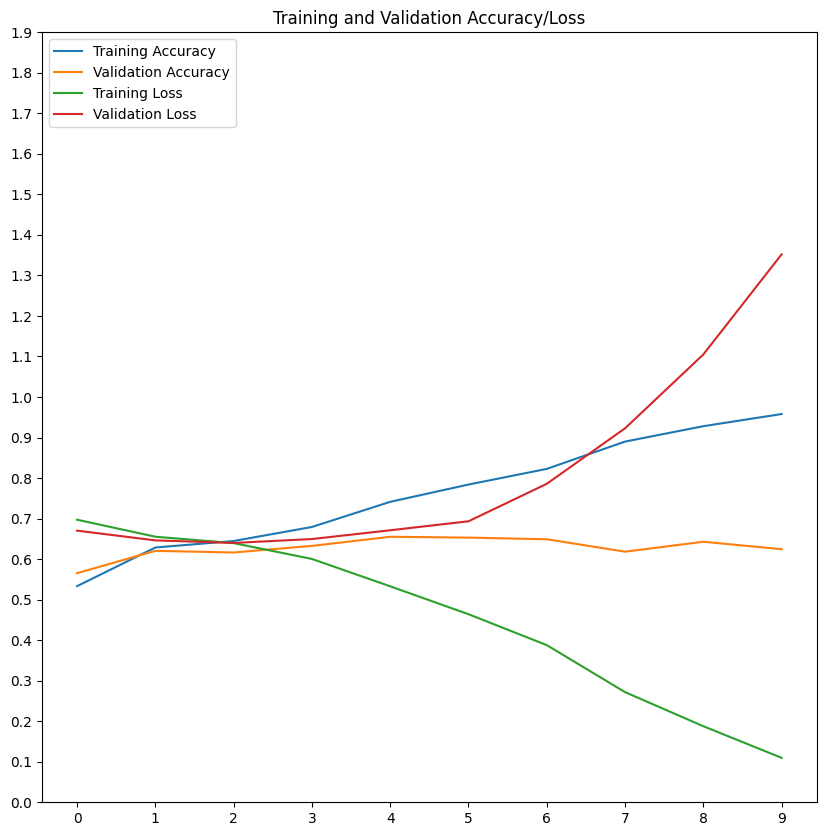

In [ ]:
visualiseMetrics(history)

####Findings

---

*   Overall training metrics show good performance, high training accuracy and decreasing training loss show the model is fitting the data well.
*   When ananlysing validation metrics we can see that validation accuracy is plateauing within 4/5 epochs & validation isn't decreasing constantly in comparison to the training loss. As loss is a measure of bad predictions where greater the number the greater the error, we can see general overfitting occuring within the model (Google, 2019).









###Classifacation Report & ROC Curve

---



In [ ]:
#Creating ROC and CR helper functions
def roc_cr(y_true, y_pred, y_pred_binary):

  #Setting label names
  target_names = ["dogs", "cats"]

  #Generating classifacation report
  print(classification_report(y_true, y_pred_binary, target_names = target_names))

  #Calculating true/false positive rates for ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  i = np.linspace(0, 1)

  #Plotting ROC
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
  ax.plot(i, i, label = 'Random Classifier')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('ROC Curve of Cats and Dogs Classifier')
  ax.legend(loc='lower right')
  plt.show()

def cr(y_true, y_pred, y_pred_binary):
  target_names = ["dogs", "cats"]
  cr = classification_report(y_true, y_pred_binary, target_names = target_names)
  return print(cr)

              precision    recall  f1-score   support

        dogs       0.63      0.58      0.60       498
        cats       0.61      0.65      0.63       495

    accuracy                           0.62       993
   macro avg       0.62      0.62      0.62       993
weighted avg       0.62      0.62      0.62       993



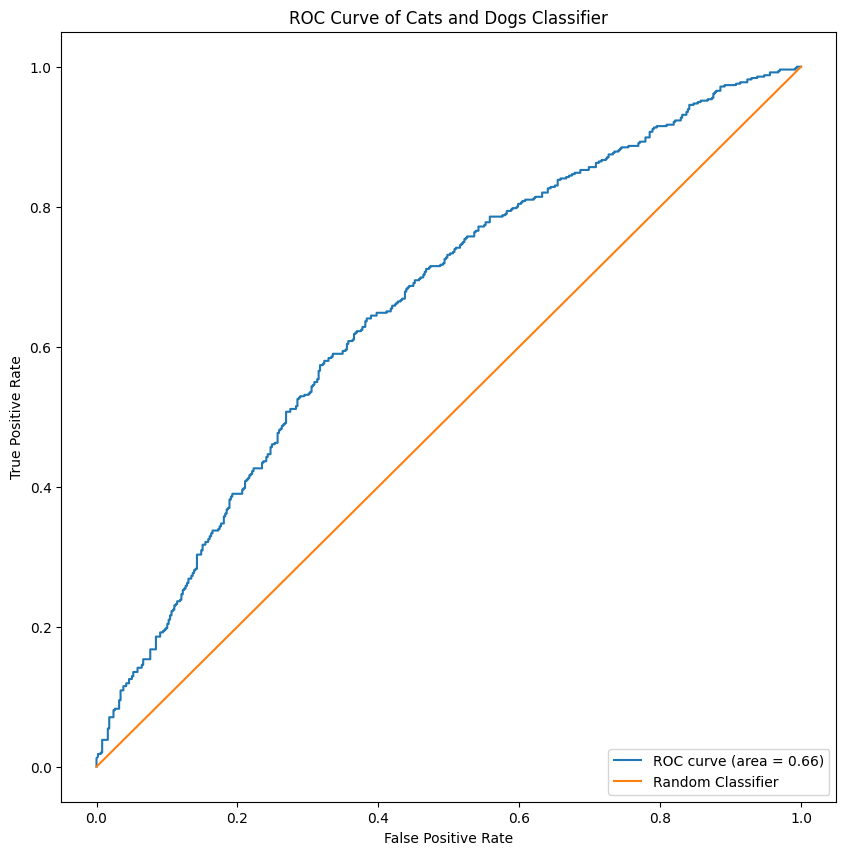

In [ ]:
roc_cr(y_test, y_pred, y_pred_binary)

####Findings


---




*   Area Under Curve (AOC) which is the probability that a random sample is more likely to be positive than negative. An AOC of 0.5 (orange would be the same as a random classifier) shows us that model performs better than random classifacation. AOC is a good general measure of accuracy and as the curve moves closer to 1, accuracy of the model increases (Hoo, Candlish and Teare, 2017).


*   Classifacation report reflects what was shown within the previous confusion matrix, demonsrating similar precision, recall and f1 scores.


#Using Data Augmentation to Generate New Data to Prevent Over Fitting

---



##Generating Augmented Data

---



As previously mentioned we can create new instances of data to enlarge our dataset by augmenting our existing data. This is carried out below where our previous model is then trained on new augmented data and augmented data is concatinated with original data for testing in future models.

In [ ]:
#Augmenting original training data and using data generator

aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, #images are rotated
    width_shift_range=0.2, #views of images are shifted on the x axis
    height_shift_range=0.2, #views of iamges are shifted on the y axis
    shear_range=0.2, #skews images on both x and y axis
    zoom_range=0.2, #images can be zoomed in or out
    horizontal_flip=True) #flips the image on the axis


aug_generator = aug_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  #Images are scaled to same 150x150 size
        batch_size=20, #Images are processed at this batch size
        shuffle=True, #Randomly sort the images
        class_mode='binary') #Binary labels are assinged in this scenario for binary image classifacation using binary crossentropy.

Found 1990 images belonging to 2 classes.


In [ ]:
# initialise arrays for x and y augmented datasets
x_aug, y_aug = [], []

# Appends data and labels for augmentated data
for data, label in train_generator:
  x_aug.append(data)
  y_aug.append(label)
  if len(x_aug) * aug_generator.batch_size >= aug_generator.samples:
    break

#Concatinates augmentated data together
x_aug_train = np.concatenate(x_aug)
y_aug_train = np.concatenate(y_aug)

In [ ]:
#Concatinates augmented data with original training data for future model usage
x_aug_train_concat = np.concatenate([x_aug_train, x_train])
y_aug_train_concat = np.concatenate([y_aug_train, y_train])

#Splitting concatinated and original data into larger train and validation sets for future comparisons

x_train_split_concat, x_val_split_concat = x_aug_train_concat[:3500, ...], x_aug_train_concat[3500:, ...]

y_train_split_concat, y_val_split_concat = y_aug_train_concat[:3500, ...], y_aug_train_concat[3500:, ...]

#Free up memory
del x_aug_train_concat
del y_aug_train_concat
gc.collect()

150953

In [ ]:
#Checking array shapes

data = [x_train_split_concat, x_val_split_concat, x_test, y_train_split_concat, y_val_split_concat, x_test, y_test]

for i in data:
  print(i.shape)

(3500, 150, 150, 3)
(480, 150, 150, 3)
(993, 150, 150, 3)
(3500,)
(480,)
(993, 150, 150, 3)
(993,)


As a result of this augmentation we are now much closed to the ideal test/train/validate ratio of 70% train data previously mentioned.

##Fitting Augmented Data to Previous Model

---



In [ ]:
#Loading original model after fitting with original training data
CNN_AUG = load_model('my_model')

In [ ]:
#2nd round fitting of inital model with new augmented data

aug_history = CNN_AUG.fit(x_aug_train,
            y_aug_train,
            batch_size = 32,
            epochs = 10,
            validation_data = (x_val_split, y_val_split))

y_pred_aug = CNN_AUG.predict(x_test)
y_pred_binary_aug = (y_pred_aug > 0.5)

Epoch 1/10
63/63 [==============================] - 4s 26ms/step - loss: 0.3719 - acc: 0.8744 - val_loss: 0.4325 - val_acc: 0.7959
Epoch 2/10
63/63 [==============================] - 1s 16ms/step - loss: 0.2009 - acc: 0.9261 - val_loss: 0.2322 - val_acc: 0.9102
Epoch 3/10
63/63 [==============================] - 1s 16ms/step - loss: 0.1071 - acc: 0.9568 - val_loss: 0.1168 - val_acc: 0.9571
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0650 - acc: 0.9794 - val_loss: 0.0952 - val_acc: 0.9653
Epoch 5/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0470 - acc: 0.9859 - val_loss: 0.0307 - val_acc: 0.9898
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0345 - acc: 0.9889 - val_loss: 0.0240 - val_acc: 0.9939
Epoch 7/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0187 - acc: 0.9960 - val_loss: 0.0141 - val_acc: 0.9980
Epoch 8/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0219 - a

## CNN Model Evaluation with Augmented Data

---


###Confusion Matrix

---

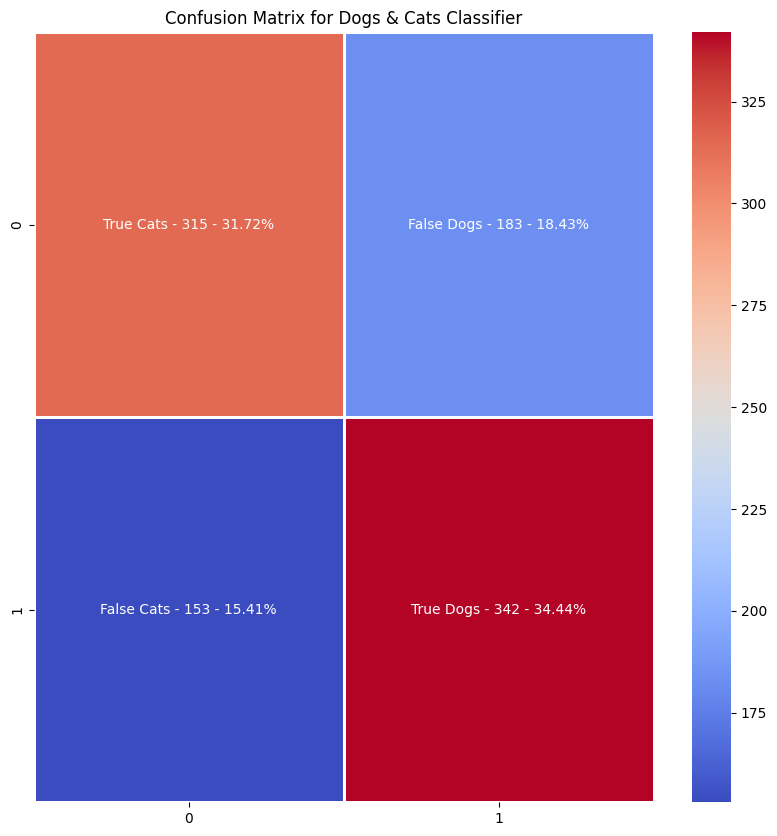

In [ ]:
#Plotting Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred_binary_aug)
matrixHelper(cf_matrix, 'Confusion Matrix for Dogs & Cats Classifier')

####Findings

---

* Confusion matrix of fitting augmented data shows margianl performance gains over standard data set.

###Visualising Accuracy/Loss

---



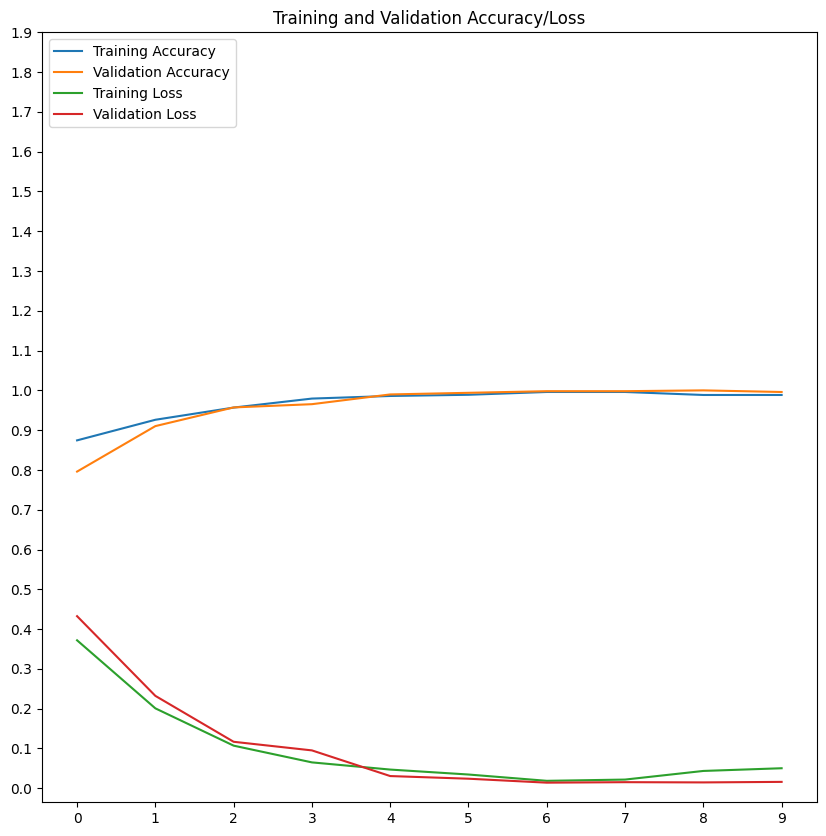

In [ ]:
visualiseMetrics(aug_history)

####Findings

---

* We can see that the model is fitting the augmented data well with accuracy and loss lines close to each other. Compared to standard data set, we can see less overfitting here with no exoponential loss seen.

###Classifacation Report & ROC Curve

---



              precision    recall  f1-score   support

        dogs       0.67      0.63      0.65       498
        cats       0.65      0.69      0.67       495

    accuracy                           0.66       993
   macro avg       0.66      0.66      0.66       993
weighted avg       0.66      0.66      0.66       993



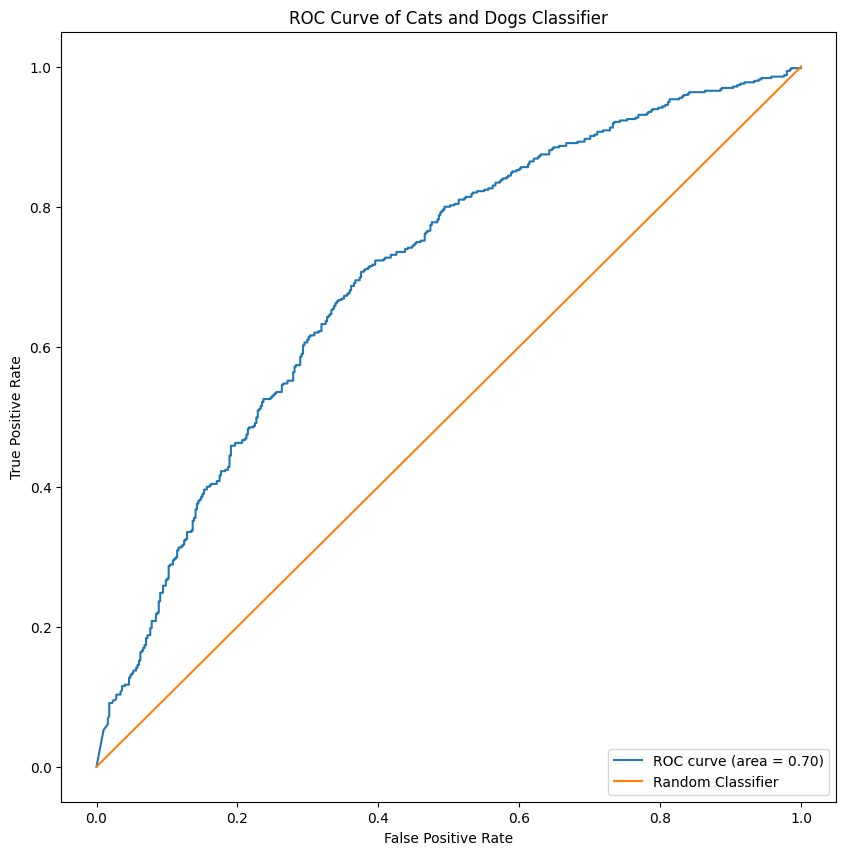

In [ ]:
roc_cr(y_test, y_pred_aug, y_pred_binary_aug)

####Findings

---

* ROC curve again highlights marginal performance gains over original standard data set with a higher ROC area.

#Improving Model Performance with Hyper Parameter Tuning

---



As mentioned, hyperparameters play a large part in determining model performace (Yeh et al., 2021). Calculating optimum performance for these models can be done using methods such as grid, random and informed search. Below, bayesian optimisation will be used to performed informed search to tune these parameters.

In [ ]:
# Define the model
def hp_model(hp):

    model = Sequential()

    #Loop to create model with search function designated amount of layers
    for i in range(hp.Int('num_layers', 2, 4)):
        if i == 0:
            #Search function change alter number of nodes between 16 and 64
            model.add(Conv2D(hp.Int('num_nodes_0', 16, 64), (3, 3), activation ='relu', input_shape = (150, 150, 3), strides = 1, padding = 'same'))

        else:
            model.add(Conv2D(hp.Int(f'num_nodes_{i}', 16, 64), (3, 3), activation ='relu', input_shape = (150, 150, 3), strides = 1, padding = 'same'))

        model.add(MaxPooling2D((2, 2), strides = 2))

        #Loop can add differeing amount of dropout rates
        if hp.Float('dropout_rate', 0.0, 0.5) > 0.0:
            model.add(Dropout(rate=hp.Float('dropout_rate', 0.0, 0.5)))

    #Flattens the current created model
    model.add(Flatten())

    #Adds a final fully connected layer
    model.add(Dense(512, activation = 'relu'))

    #Adds another layer of dropout
    if hp.Float('dropout_rate', 0.0, 0.5) > 0.0:
        model.add(Dropout(rate=hp.Float('dropout_rate', 0.0, 0.5)))

    #Final output layer for image classifacation
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

Bayesian optimisation has been chosen as the preffered search model to try and identify ideal hyperparameters quicker by learning from trials.

In [ ]:
# Define the search space for each hyperparameter
tuner = BayesianOptimization(
    hp_model,
    objective='val_acc',
    max_trials=10,
    directory='my_dir',
    project_name='my_project'
)

# Model searches for best parameters within defined search space
tuner.search(
    x_train_split_concat,
    y_train_split_concat,
    epochs=10,
    batch_size=128,
    validation_data = (x_val_split, y_val_split)
)

Trial 10 Complete [00h 00m 36s]
val_acc: 0.6510204076766968

Best val_acc So Far: 0.9142857193946838
Total elapsed time: 00h 08m 03s


In [ ]:
# Get the best hyperparameters from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tunedModel = tuner.hypermodel.build(best_hps)

#Model is created from best hyperparameters
tunedModelHistory = tunedModel.fit(
    x_train_split_concat,
    y_train_split_concat,
    epochs=20,
    batch_size=128,
    validation_data=(x_val_split, y_val_split)
)

#New model predicts against same test data set.
y_pred_BO = tunedModel.predict(x_test)
y_pred_binary_BO = (y_pred_BO > 0.5)

Epoch 1/20
28/28 [==============================] - 5s 100ms/step - loss: 1.0159 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.4898
Epoch 2/20
28/28 [==============================] - 2s 84ms/step - loss: 0.6925 - acc: 0.5126 - val_loss: 0.6907 - val_acc: 0.5551
Epoch 3/20
28/28 [==============================] - 2s 85ms/step - loss: 0.6768 - acc: 0.5709 - val_loss: 0.6555 - val_acc: 0.6388
Epoch 4/20
28/28 [==============================] - 2s 84ms/step - loss: 0.6263 - acc: 0.6589 - val_loss: 0.6174 - val_acc: 0.6429
Epoch 5/20
28/28 [==============================] - 2s 85ms/step - loss: 0.5830 - acc: 0.6869 - val_loss: 0.5600 - val_acc: 0.7184
Epoch 6/20
28/28 [==============================] - 2s 86ms/step - loss: 0.4970 - acc: 0.7557 - val_loss: 0.5155 - val_acc: 0.7694
Epoch 7/20
28/28 [==============================] - 2s 87ms/step - loss: 0.4499 - acc: 0.7791 - val_loss: 0.4684 - val_acc: 0.7735
Epoch 8/20
28/28 [==============================] - 2s 88ms/step - loss: 0.3813 - 

## Evaluating Tuning Hyperparameters

---



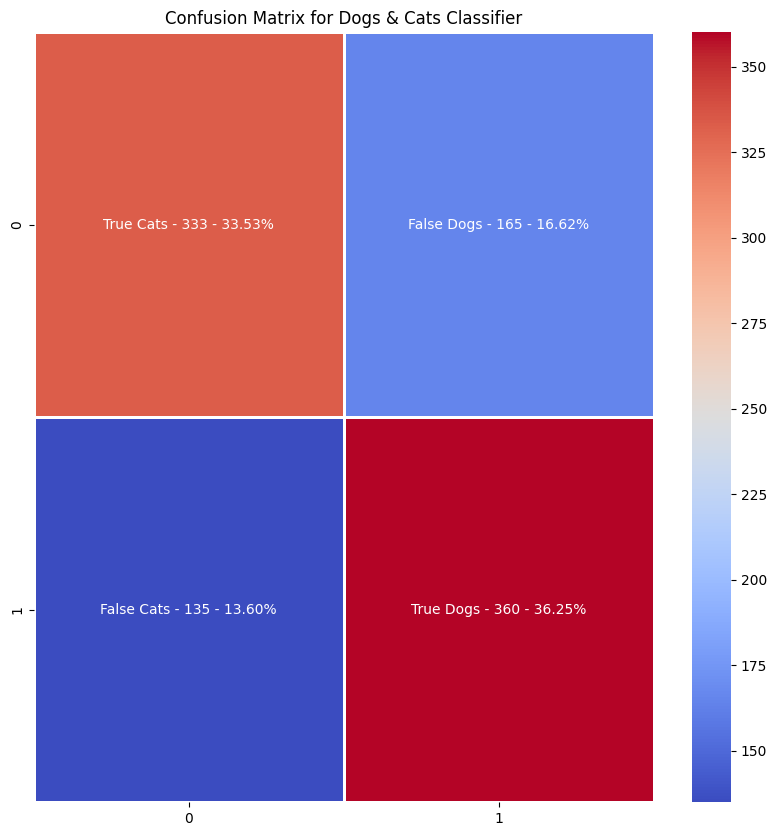

In [ ]:
#Plotting Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred_binary_BO)
matrixHelper(cf_matrix, 'Confusion Matrix for Dogs & Cats Classifier')

####Findings

---

* Hyperparameter tuning here shows margianl gains in performance compared to original model. This requires further investigation.

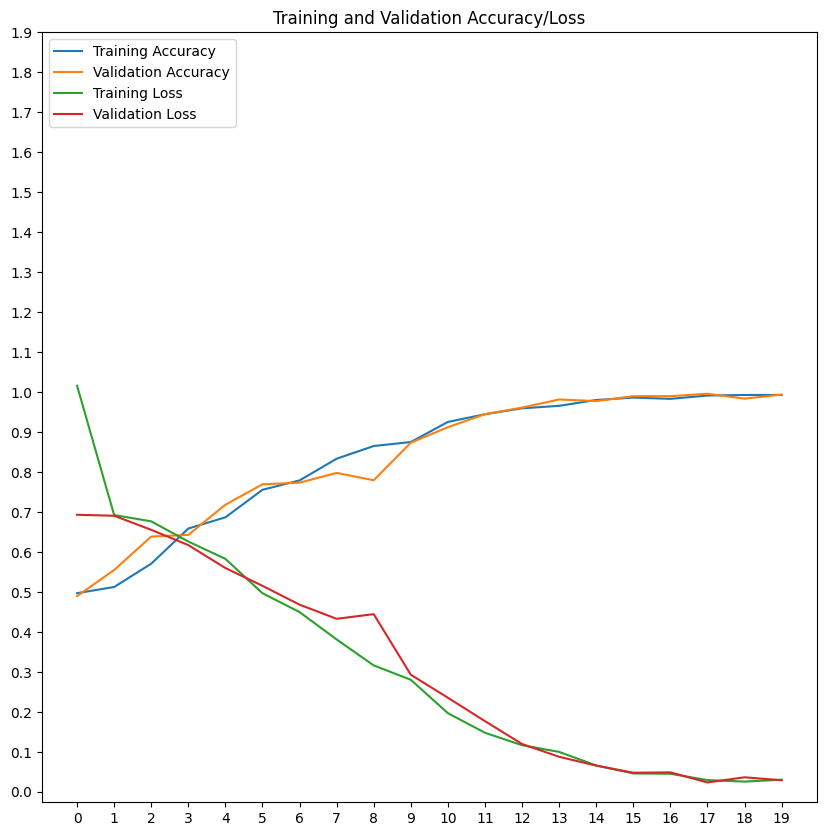

In [ ]:
visualiseMetrics(tunedModelHistory)

####Findings

---

* We can see that the hyperparameter tuned model is fitting the data well with no exponential losses in either training or validation set.

              precision    recall  f1-score   support

        dogs       0.71      0.67      0.69       498
        cats       0.69      0.73      0.71       495

    accuracy                           0.70       993
   macro avg       0.70      0.70      0.70       993
weighted avg       0.70      0.70      0.70       993



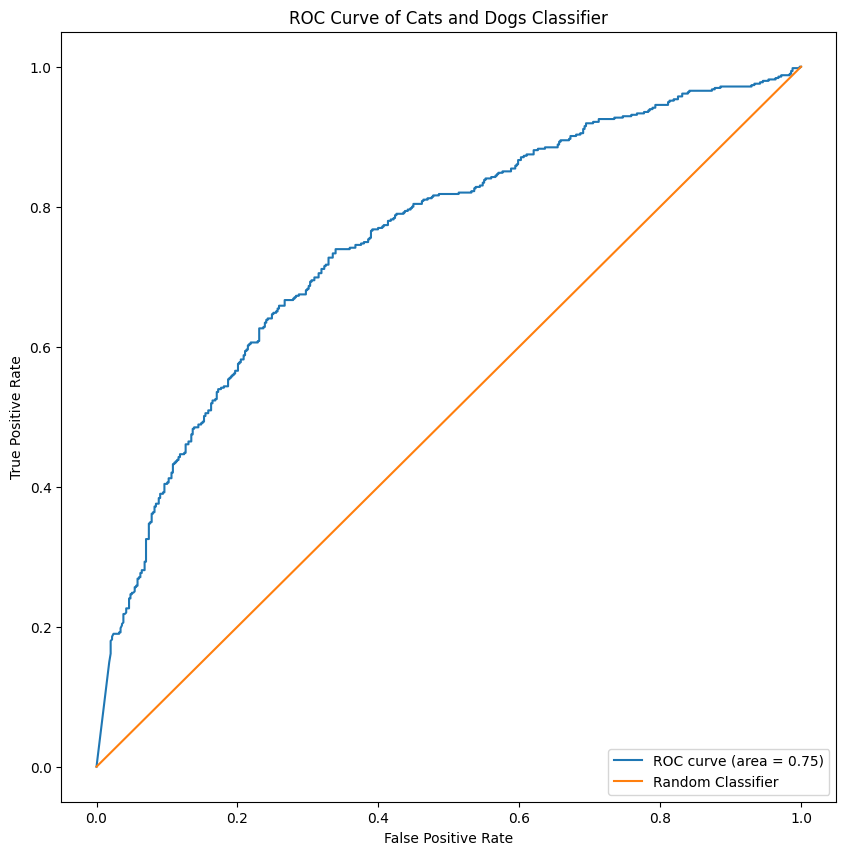

In [ ]:
roc_cr(y_test, y_pred_BO, y_pred_binary_BO)

####Findings

---

* ROC curve highlights marginal performance gains over original. This could be due to the low search space which the search function was given. This decision was made with a comprimise to preserve performance as informed search of hyperparameters is computationally expensive with image CNNs. This difficulty has been discussed by Chen et al., 2021.

#Leveraging Pre-Trained Models

---



VGG-16 has been chosen as the model to leverage transfer learning to use for this image classifier. VGG-16 is trained using ImageNet which has over 20,000 categories of images including animals, which makes it an appropiate fit for this use case (Image-net, 2020).

In [ ]:
#Create a copy of VGG16 and define input shape
base_model = VGG16(input_shape = (150, 150, 3),
include_top = False, # Removes final fully connected layer
weights = 'imagenet')

#Loops through layers and prevents VGG weights from being changed
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Flatten original VGG-16 model
VGG = layers.Flatten()(base_model.output)

# Adding fully connected layer with 512 hidden units and ReLU activation
VGG = layers.Dense(512, activation='relu')(VGG)

# Adding dropout
VGG = layers.Dropout(0.5)(VGG)

# Add final output layer with sigmoid for classifacation
VGG = layers.Dense(1, activation='sigmoid')(VGG)

VGG = tf.keras.models.Model(base_model.input, VGG)

VGG.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
#Fitting train data to model

VGG_history = VGG.fit(x_train_split_concat,
            y_train_split_concat,
            steps_per_epoch = 75, #Setting hyper parameters
            epochs = 20,
            validation_data = (x_val_split_concat, y_val_split_concat))

#Classifying results from model
vgg_pred = VGG.predict(x_test)
vgg_pred_binary = (vgg_pred > 0.5)

Epoch 1/20
75/75 [==============================] - 10s 116ms/step - loss: 0.8480 - acc: 0.7557 - val_loss: 0.2533 - val_acc: 0.8875
Epoch 2/20
75/75 [==============================] - 8s 113ms/step - loss: 0.3101 - acc: 0.8680 - val_loss: 0.2446 - val_acc: 0.8896
Epoch 3/20
75/75 [==============================] - 9s 115ms/step - loss: 0.2348 - acc: 0.9051 - val_loss: 0.1859 - val_acc: 0.9208
Epoch 4/20
75/75 [==============================] - 9s 116ms/step - loss: 0.1995 - acc: 0.9191 - val_loss: 0.1472 - val_acc: 0.9396
Epoch 5/20
75/75 [==============================] - 9s 118ms/step - loss: 0.1481 - acc: 0.9440 - val_loss: 0.2254 - val_acc: 0.9021
Epoch 6/20
75/75 [==============================] - 9s 118ms/step - loss: 0.1307 - acc: 0.9523 - val_loss: 0.1102 - val_acc: 0.9542
Epoch 7/20
75/75 [==============================] - 9s 116ms/step - loss: 0.1165 - acc: 0.9557 - val_loss: 0.0880 - val_acc: 0.9646
Epoch 8/20
75/75 [==============================] - 9s 115ms/step - loss: 0

## Pre Trained Model Evaluation

---

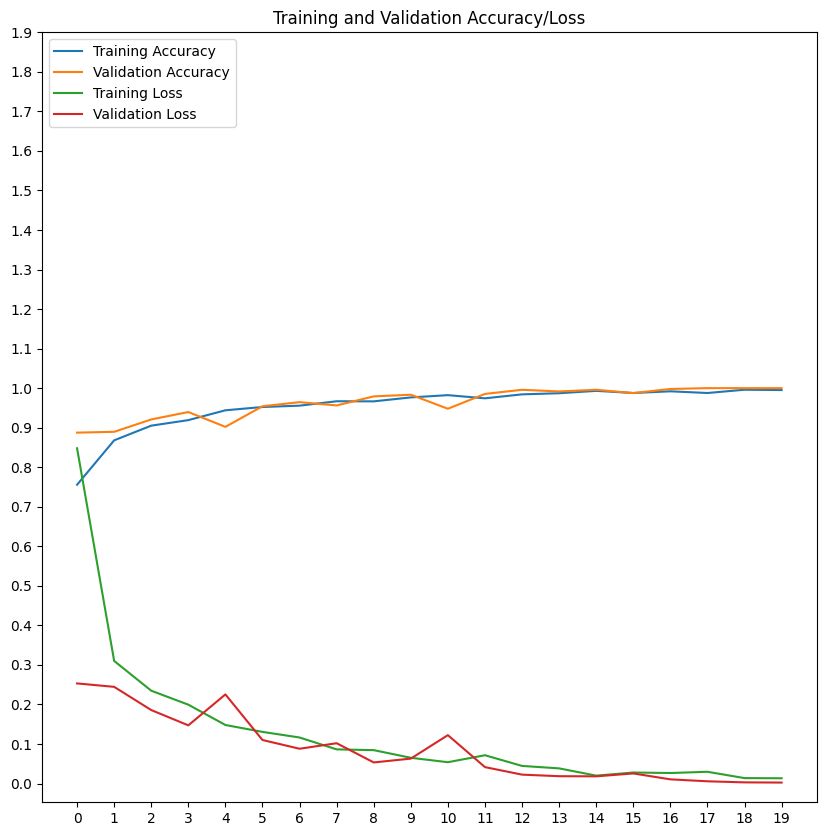

In [ ]:
visualiseMetrics(VGG_history)

####Findings

---

Metric analysis shows good data fitting of both training and validation data set with no overfitting.

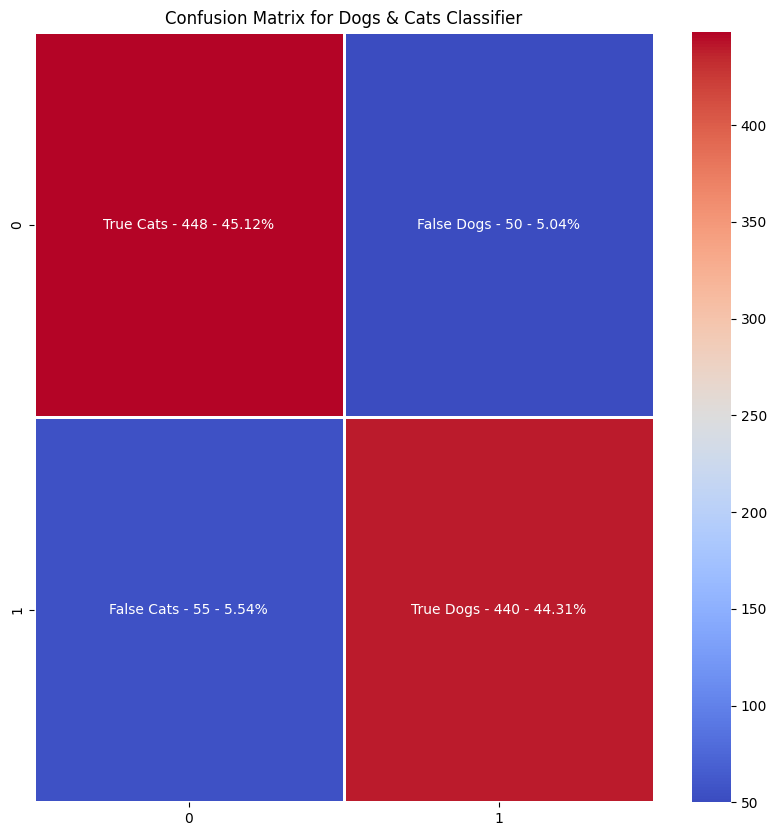

In [ ]:
cf_matrix_vgg = confusion_matrix(y_test, vgg_pred_binary)
matrixHelper(cf_matrix_vgg, 'Confusion Matrix for Dogs & Cats Classifier')

####Findings

---

Confusion matrix shows best performance seen so far, with almost 90% of images being classified correctly.

              precision    recall  f1-score   support

        dogs       0.89      0.90      0.90       498
        cats       0.90      0.89      0.89       495

    accuracy                           0.89       993
   macro avg       0.89      0.89      0.89       993
weighted avg       0.89      0.89      0.89       993



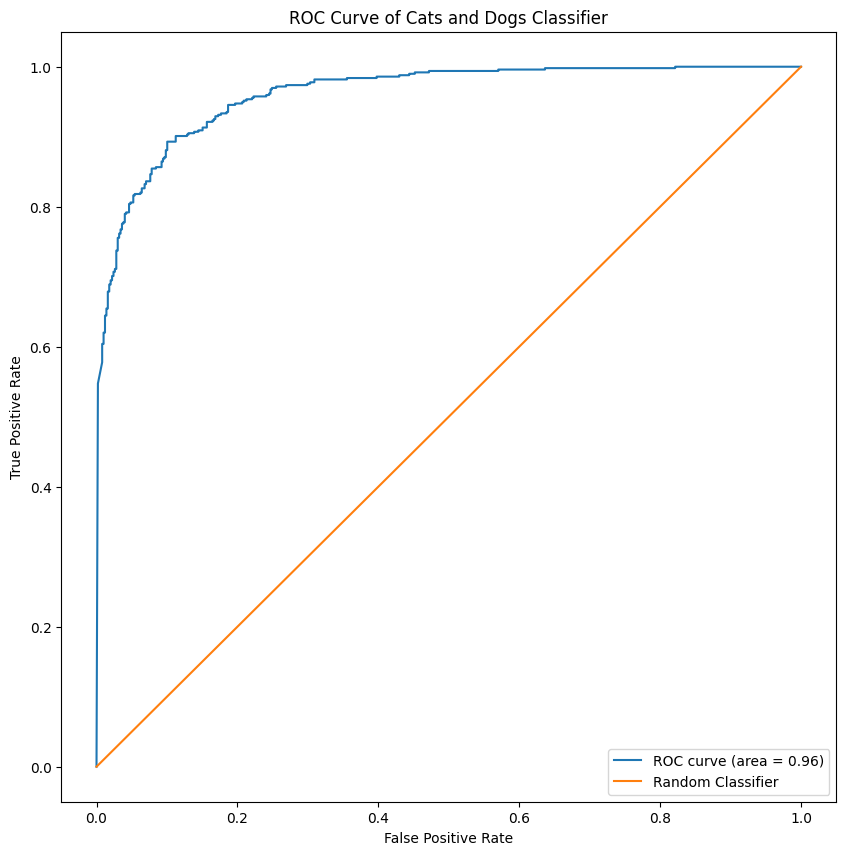

In [ ]:
roc_cr(y_test, vgg_pred, vgg_pred_binary)

####Findings

---

ROC curve affirms pre-trained model excellent performance shown in confusion matrix, with a 0.96 area under the ROC curve.

#Summary

---



In [ ]:
print("------------------------------------------Origial Training Dataset Model 2000 Images-----------------------------------------")
cr(y_test, y_pred, y_pred_binary)
print("------------------Original Model 2000 Images then fitted with 2000 Augemnted Images in 2nd Round of Fitting------------------")
cr(y_test, y_pred_aug, y_pred_binary_aug)
print("------------------------------------------------Hyper Parameter Tuned Model--------------------------------------------------")
cr(y_test, y_pred_BO, y_pred_binary_BO)
print("--------------------------------------------------Pre Trained Model (VGG-16)-------------------------------------------------")
cr(y_test, vgg_pred, vgg_pred_binary)

------------------------------------------Origial Training Dataset Model 2000 Images-----------------------------------------
              precision    recall  f1-score   support

        dogs       0.63      0.58      0.60       498
        cats       0.61      0.65      0.63       495

    accuracy                           0.62       993
   macro avg       0.62      0.62      0.62       993
weighted avg       0.62      0.62      0.62       993

------------------Original Model 2000 Images then fitted with 2000 Augemnted Images in 2nd Round of Fitting------------------
              precision    recall  f1-score   support

        dogs       0.67      0.63      0.65       498
        cats       0.65      0.69      0.67       495

    accuracy                           0.66       993
   macro avg       0.66      0.66      0.66       993
weighted avg       0.66      0.66      0.66       993

------------------------------------------------Hyper Parameter Tuned Model-------------------

Overall we can see a growing trend of performance as the model develops from the original attempt. Firstly, by augmenting the dataset we an marginally improve accuracy of the classifier. Further performance could be achieved with more augmentations of the data set but computational expenses have been factored into this consideration.

Secondly, the hyperparameter tuned model using Bayesian Optimisation unfortunately showed only a small performance increase. As mentioned this is likely due to the small search space the search function was given based on computational resources. Given more resources, this could definitely prodive more scope in the future to pursue this option further.

Finally, the pretrained VGG-16 model adpated for this scenario demonstrated excellent performance over the rest with an overal accuracy of 0.88. This demonstrates the power of VGG-16 and pre-trained models in general in both their performance and resourcefullness of computation by allowing intense tasks such as training to be handled elsewhere which can then be leveraged.

#Word Count

---



In [ ]:
file_name = '/content/gdrive/MyDrive/Colab Notebooks/BP0260990_ML&AI_Part1_Summative_Cats&Dogs_Classifier.ipynb'

import nbformat
nb = nbformat.read(file_name, as_version=3)
heading = 0
markdown = 0
code = 0
totaltext = 0

for cell in nb.worksheets[0].cells:
  if cell.cell_type == "heading":
    heading += len(cell['source'].replace('#', '').lstrip().split(' '))
  elif cell.cell_type == "markdown":
    markdown += len(cell['source'].replace('#', '').lstrip().split(' '))
  elif cell.cell_type == "code":
    code += len(cell['input'].replace('#', '').lstrip().split(' '))
heading = heading-2 #Manually remove wordcount in References cell and heading of Word count cell
markdown = markdown-19 #Manually remove wordcount in References cell
totaltext = heading+markdown
print("Word Counts:\nHeadings = %s\nMarkdown = %s\nCode = %s\nTotalText = %s" % (heading, markdown, code, totaltext))

Word Counts:
Headings = -2
Markdown = 2336
Code = 2800
TotalText = 2334


#References

---



 Afaq, S. and Rao, S. (2020). Significance Of Epochs On Training A Neural Network. [online] IJSTR, pp.485–488. Available at: https://www.ijstr.org/final-print/jun2020/Significance-Of-Epochs-On-Training-A-Neural-Network.pdf [Accessed 7 Apr. 2023].

 Chen, L., Li, S., Bai, Q., Yang, J., Jiang, S. and Miao, Y. (2021). Review of Image Classification Algorithms Based on Convolutional Neural Networks. Remote Sensing, [online] 13(22), p.4712. doi:https://doi.org/10.3390/rs13224712. [Accessed 13 May. 2023]

 Dubey, S.R., Singh, S.K. and Chaudhuri, B.B. (2022). Activation functions in deep learning: A comprehensive survey and benchmark. Neurocomputing, [online] 503, pp.92–108. doi:https://doi.org/10.1016/j.neucom.2022.06.111. [Accessed 4 Apr. 2023]

 GeeksforGeeks (2019). CNN | Introduction to Pooling Layer. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/ [Accessed 12 Apr. 2023].

 Google (2019). Descending into ML: Training and Loss  |  Machine Learning Crash Course. [online] Google Developers. Available at: https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss [Accessed 9 Apr. 2023].

 Hoo, Z.H., Candlish, J. and Teare, D. (2017). What is an ROC curve? Emergency Medicine Journal, [online] 34(6), pp.357–359. doi:https://doi.org/10.1136/emermed-2017-206735. [Accessed 9 Apr. 2023].

 Image-net (2020). ImageNet. [online] www.image-net.org. Available at: https://www.image-net.org/download.php [Accessed 7 May 2023].

 Jepkoech, J., Mugo, D.M., Kenduiywo, B.K. and Too, E.C. (2021). The Effect of Adaptive Learning Rate on the Accuracy of Neural Networks. International Journal of Advanced Computer Science and Applications, 12(8), pp.736–751. doi:https://doi.org/10.14569/ijacsa.2021.0120885. [Accessed 9 Apr. 2023].

 Joseph, V.R. (2022). Optimal ratio for data splitting. Statistical Analysis and Data Mining: The ASA Data Science Journal, [online] 15(4), pp.531–538. doi:https://doi.org/10.1002/sam.11583. [Accessed 9 Apr. 2023].

 Nie, F., Hu, Z. and Li, X. (2018). An investigation for loss functions widely used in machine learning. Communications in Information and Systems, [online] 18(1), pp.37–52. doi:https://doi.org/10.4310/CIS.2018.v18.n1.a2. [Accessed 4 Apr. 2023]

 Richter, M.L., Bytner, W., Krumnack, U., Schallner, L. and Shenk, J. (2021). Size Matters. arXiv. [online] doi:arxiv:2102.01582v2. [Accessed 12 Apr. 2023].


 Rosebrock, A. (2021). Convolutional Neural Networks (CNNs) and Layer Types. [online] PyImageSearch. Available at: https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/ [Accessed 11 Apr. 2023].

 Sharma, P. (2020). Keras Dense Layer Explained for Beginners. [online] MLK - Machine Learning Knowledge. Available at: https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/ [Accessed 12 Apr. 2023].

 Shorten, C. and Khoshgoftaar, T.M. (2019). A survey on Image Data Augmentation for Deep Learning. Journal of Big Data, [online] 6(1). doi:https://doi.org/10.1186/s40537-019-0197-0. [Accessed 9 Apr. 2023].

 Singh, D. and Singh, B. (2019). Investigating the impact of data normalization on classification performance. Applied Soft Computing, [online] p.105524. doi:https://doi.org/10.1016/j.asoc.2019.105524. [Accessed 19 Apr. 2023].

 Srivastava, N., Hinton, G., Krizhevsky, A. and Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, [online] 15, pp.1929–1958. Available at: https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf [Accessed 13 Apr. 2023].

 Yeh, W.-C., Lin, Y.-P., Liang, Y.-C. and Lai, C.-M. (2021). Convolution Neural Network Hyperparameter Optimization Using Simplified Swarm Optimization. arXiv:2103.03995 [cs]. [online] doi:https://doi.org/10.48550/arXiv.2103.03995. [Accessed 28 Apr. 2023].